## Assignment - Sentiment Analysis Using Naive Bayes 

In [1]:
#Import necessary libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK stop words 
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

__1. Read dataset and perform Text processing for the tweets ( Remove Stop words, and special characters and convert the text to lowercase)__

In [2]:
# Load the datasets
train_data_path = "Corona_NLP_train.csv"
test_data_path = "Corona_NLP_test.csv"

train_data = pd.read_csv(train_data_path, encoding="latin-1")
test_data = pd.read_csv(test_data_path, encoding="latin-1")

# Preprocessing Function
def preprocess_text(text):
    stop_words = set(stopwords.words("english"))
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Remove stop words
    words = text.split()
    filtered_text = " ".join([word for word in words if word not in stop_words])
    return filtered_text

# Preprocess the tweets on train dataset and print few.
train_data["ProcessedTweet"] = train_data["OriginalTweet"].apply(preprocess_text)

train_data["ProcessedTweet"].head()

0    menyrbie philgahan chrisitv httpstcoifzfanpa h...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid outbreak im paranoi...
Name: ProcessedTweet, dtype: object

__2. Using the train_test_split function of Sklearn, Split the kaggle's train dataset further into train, and test dataset__

In [3]:
# Splitting the train data into train and test sets
X = train_data["ProcessedTweet"]
y = train_data["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

__3. Use BoW and TF-IDF based feature extraction approaches on the "text" field of the dataset. You can use existing library functions__

In [4]:
# Feature Extraction: BoW and TF-IDF
# Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

__4. Create model building pipeline and define parameters for GridSearch (You might Refer to the code below)__

In [5]:
# Model Pipeline and GridSearch
text_clf = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", MultinomialNB())
])

tuned_parameters = {
    "vect__ngram_range": [(1, 1), (1, 2), (2, 2)],
    "tfidf__use_idf": [True, False],
    "tfidf__norm": ["l1", "l2"],
    "clf__alpha": [1, 0.1, 0.01]
}

grid_search = GridSearchCV(text_clf, tuned_parameters, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'clf__alpha': 0.01, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
Best Score: 0.4454062262718299


__5. Perform classification (using GridSearch)__

In [6]:
# Use the best model to predict on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.52      0.34      0.41      1056
Extremely Positive       0.56      0.36      0.43      1330
          Negative       0.40      0.48      0.43      2006
           Neutral       0.67      0.35      0.46      1553
          Positive       0.40      0.61      0.48      2287

          accuracy                           0.45      8232
         macro avg       0.51      0.43      0.44      8232
      weighted avg       0.49      0.45      0.45      8232



__6. Print the confusion matrix, accuracy, and F1 score on the test dataset__

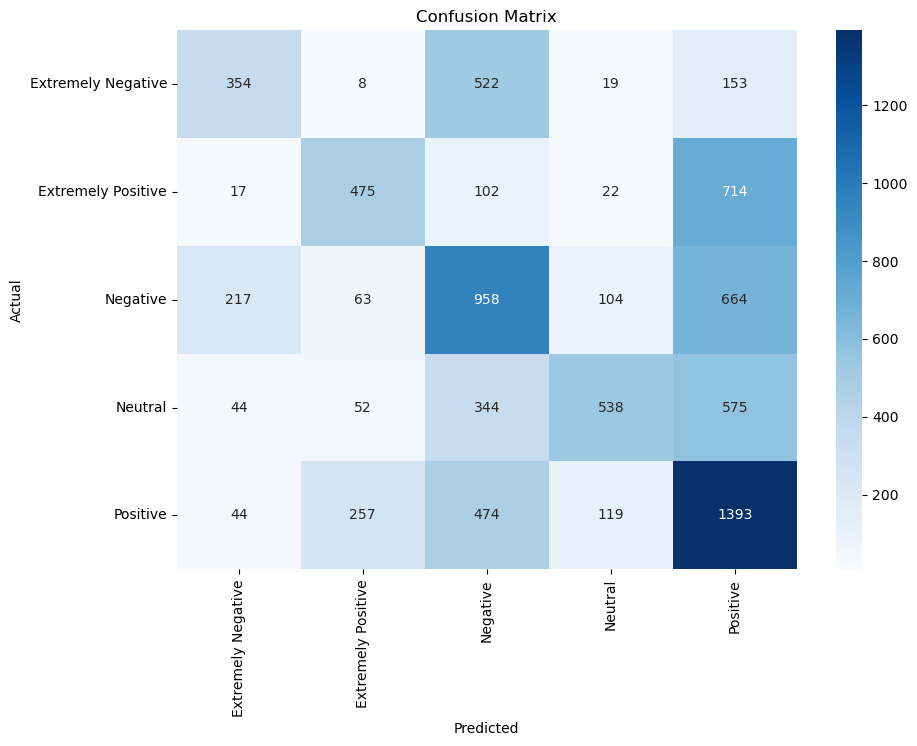

Accuracy: 0.4516520894071914
F1 Score: 0.4486192074577366


In [7]:
# Evaluate the model
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred, average="weighted")  # Weighted average for multi-class
print("F1 Score:", f1)

__7. Interpret your results in terms of Business Domain Knowledge__

1. General Observations  

Accuracy (45.2%):  
The model correctly predicts the sentiment of tweets in less than half of the cases. For a public health context, this is a low performance that might hinder precise sentiment understanding.  


Weighted F1 Score (44.9%):  
A balance between precision and recall suggests the model performs moderately well but struggles to generalize across all sentiment classes.  

Macro Avg F1 Score (44%):  
Indicates inconsistent performance across different sentiment classes, particularly for extreme sentiments.  


2. Class-Specific Observations

Extremely Negative Sentiment  
Precision (52%), Recall (34%), F1 Score (41%):  
The model captures only 34% of tweets with extremely negative sentiment, which are crucial for identifying public outrage, fear, or dissatisfaction.  
Misclassifying these tweets might result in delayed responses to significant crises (e.g., complaints about health services or misinformation).  

Extremely Positive Sentiment  
Precision (56%), Recall (36%), F1 Score (43%):  
The model has difficulty detecting highly positive sentiments, capturing only 36% of such tweets. This could mean missing important appreciation for COVID-19 measures or vaccine rollouts.  
Low recall might cause the model to under-represent public gratitude or support for specific actions. 

Negative Sentiment  
Precision (40%), Recall (48%), F1 Score (43%):  
Negative tweets are captured slightly better than extremely negative ones, but precision remains low.  
This can lead to inaccurate representation of issues like vaccine hesitancy, distrust in government policies, or dissatisfaction with public health messaging.  

Neutral Sentiment  
Precision (67%), Recall (35%), F1 Score (46%):  
While the model is better at avoiding false positives for neutral tweets, it misses 65% of actual neutral tweets.  
This could impact the identification of informational or non-opinionated content (e.g., news updates or announcements).  

Positive Sentiment  
Precision (40%), Recall (61%), F1 Score (48%):  
The model captures a significant proportion of positive tweets but sacrifices precision, meaning many tweets are misclassified as positive.  
Overestimating positivity might mislead stakeholders into believing there's greater public approval for certain measures.  

3. Implications for COVID-19 Business and Public Health Use Cases

Monitoring Public Opinion:  
Challenges:  
Low recall for extreme sentiments may lead to underestimating strong opinions (e.g., frustration with lockdowns, appreciation for healthcare workers).  
Misclassification of neutral tweets could reduce the reliability of sentiment trends for general COVID-19 discussions.

Opportunities:    
The model can still provide rough sentiment trends, such as identifying broader positive or negative sentiment over time. 

Healthcare and Vaccine Campaigns:  
Challenges:  
Poor performance on negative and extremely negative tweets might hinder detection of vaccine hesitancy or misinformation.  
Missed extremely positive tweets could underrepresent public approval of vaccine rollouts or healthcare initiatives.  

Opportunities:  
The model can be used to highlight potential trends (e.g., increasing negative sentiment during new restrictions) and inform communication strategies.  

Crisis Response:  
Challenges:  
Failing to identify extreme sentiments could result in delayed responses to critical situations (e.g., panic about COVID-19 waves or healthcare shortages).  

Opportunities:  
By filtering tweets into broader categories (e.g., positive vs. negative), the model may assist in flagging content for manual review during crises.  

4. Recommendations for Improvement
To better align with the business and public health objectives:

Balance the Dataset:
Handle class imbalance by oversampling minority classes (e.g., Extremely Negative) or undersampling majority classes.

Advanced Preprocessing:
Handle domain-specific nuances like:
Negation detection (e.g., “not happy” vs. “happy”).
COVID-19 keywords, hashtags, and emojis (e.g., #StaySafe, 😷, 💉).
Use domain-specific stop words or sentiment lexicons.

Algorithmic Improvement:
Consider advanced models like Random Forests, SVM, or transformer-based models (e.g., BERT or DistilBERT) to capture contextual information.

Domain-Specific Features:
Incorporate features like hashtags, mentions, or tweet metadata (e.g., retweet count).

5. Action Plan  

Use the current model cautiously for broad sentiment trends.
Perform manual review for critical classes like Extremely Negative and Extremely Positive tweets.
Plan for iterative model improvement to address key weaknesses and enhance utility for public health decisions.